# Synthetic Features and Outliers
This notebook continues the linear regression model started in the previous exercise. In this exercise, we'll try new features and study the effect of outliers in the input data.

The code in the cells below is identical to the one in the previous section.

In [7]:
%%sql --module california_housing
SELECT total_rooms, population, median_house_value FROM $california_housing

In [8]:
import datalab.bigquery as bq
from IPython import display
import math
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = bq.Query(
    california_housing, california_housing=bq.Table('mlcc-playground:california_housing.train')
).to_dataframe()

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,total_rooms,population,median_house_value
9643,422.0,211.0,159.7
14390,504.0,789.0,91.4
10318,2085.0,1346.0,56.7
1437,1788.0,1652.0,62.4
5417,2054.0,835.0,76.9
...,...,...,...
10600,2279.0,1166.0,150.0
3622,1402.0,1327.0,53.2
11127,2705.0,1676.0,247.9
8261,706.0,399.0,166.7


In [9]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_column = california_housing_dataframe[my_feature].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create a linear regressor object.
  feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
      my_feature_column)
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        my_feature_column,
        targets,
        steps=steps_per_period,
        batch_size=batch_size
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(my_feature_column, as_iterable=False)
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error
  
  return calibration_data

### Task 1: Try a synthetic feature.

Both the `total_rooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another?

We can get at this idea by creating a synthetic feature that's a ratio of our two source features.

Create a feature called `rooms_per_person`, and use that as an input in the model code cell below.

What is the best performance you can get with this single feature? (The better the performance, the better your regression line should fit the data and the lower
the final RMSE should be.)

Training model...
RMSE (on training data):
  period 00 : 212.77
  period 01 : 189.72
  period 02 : 170.47
  period 03 : 154.68
  period 04 : 143.52
  period 05 : 135.77
  period 06 : 131.92
  period 07 : 130.42
  period 08 : 129.80
  period 09 : 129.41
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,181.6,207.3
std,80.7,116.0
min,46.1,15.0
25%,149.9,119.4
50%,178.8,180.4
75%,203.4,265.0
max,3854.3,500.0


Final RMSE (on training data): 129.41


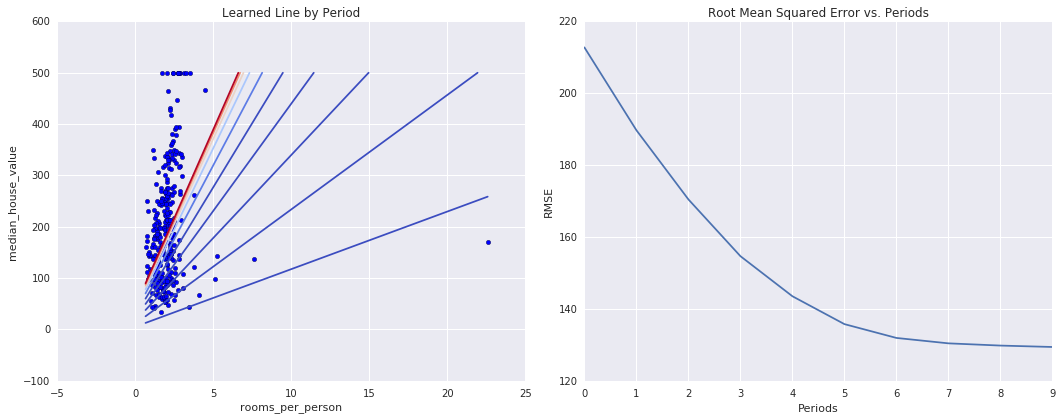

In [21]:
#
# Your code here
#
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
# california_housing_dataframe.describe()
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

### Task 2: Identify outliers.

We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.

Use Pyplot's `scatter()` to create a scatter plot of predictions vs. targets, using the rooms per person model you trained in Task 1.

Do you see any oddities?  Trace these back to their root by looking at the distribution of values in `rooms_per_person`.

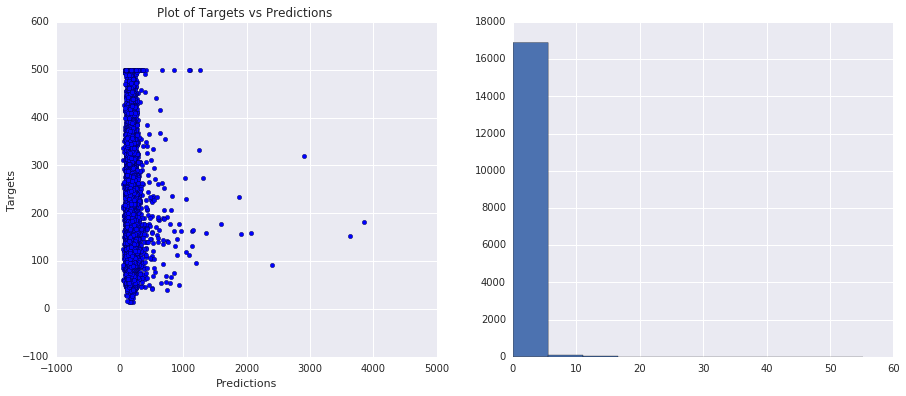

In [22]:
#
# Your code here
# plt.scatter(calibration_data['predictions'], calibration_data['targets'])
# plt.title("Plot of Targets vs Predictions ")
# plt.xlabel("Predictions")
# plt.ylabel("Targets")
# plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.title("Plot of Targets vs Predictions ")
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

### Task 3: Clip outliers.

See if you can improve model fit further by setting outlier values of `rooms_per_person` to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas `Series`:

    clipped_feature = my_feature_column["my_feature_name"].apply(lambda x: max(x, 0))

The above `clipped_feature` will have no values less than `0`.

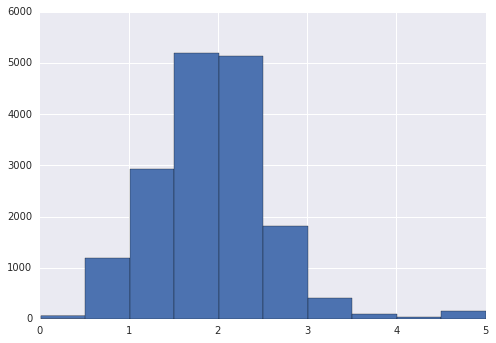

In [23]:
#
# Your code here
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.05
  period 02 : 166.70
  period 03 : 146.68
  period 04 : 131.27
  period 05 : 120.67
  period 06 : 114.52
  period 07 : 112.12
  period 08 : 110.82
  period 09 : 110.04
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,183.2,207.3
std,46.8,116.0
min,46.0,15.0
25%,153.3,119.4
50%,183.3,180.4
75%,208.7,265.0
max,401.5,500.0


Final RMSE (on training data): 110.04


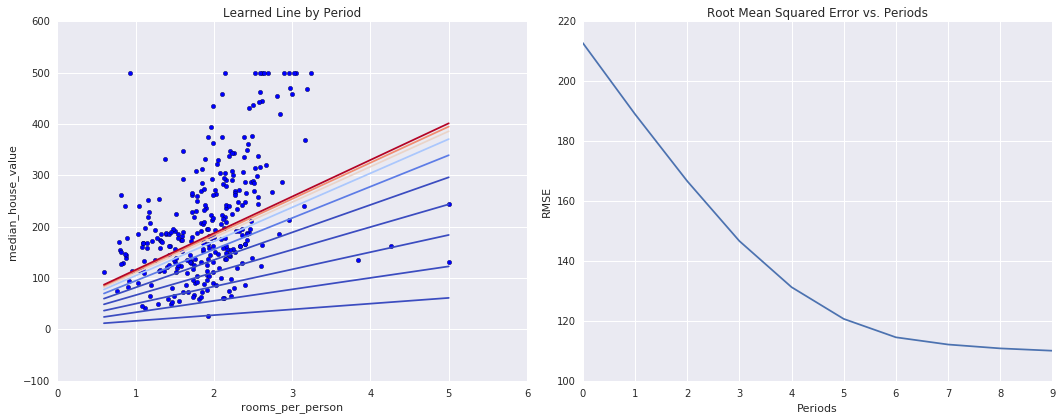

In [24]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

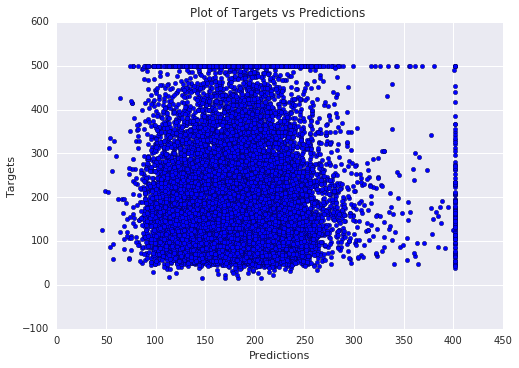

In [26]:
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.title("Plot of Targets vs Predictions ")
plt.xlabel("Predictions")
plt.ylabel("Targets")